In [1]:
from cProfile import label
import sys
import matplotlib

sys.path.append('../../toolbox/')
sys.path.append('../scan_tools')
from robot_def import *
from utils import *
from scan_utils import *
from general_robotics_toolbox import *
import open3d as o3d

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import time
from copy import deepcopy
import colorsys
import math
import pickle

table_colors = list(mcolors.TABLEAU_COLORS.values())

data_dir=''
config_dir='../../config/'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
######## read the combined point clouds
scanned_points_mesh = o3d.io.read_triangle_mesh(data_dir+'ER4043_refwall_7_trimmed.stl')

scanned_points = scanned_points_mesh.sample_points_uniformly(number_of_points=1110000)
#visualize_pcd([scanned_points_mesh,scanned_points])

In [3]:
###################### get the welding pieces ##################
# This part will be replaced by welding path in the future
######## make the plane normal as z-axis
####### plane segmentation
plane_model, inliers = scanned_points.segment_plane(distance_threshold=0.75,
                                         ransac_n=5,
                                         num_iterations=3000)
#display_inlier_outlier(scanned_points,inliers)
## Transform the plane to z=0

plain_norm = plane_model[:3]/np.linalg.norm(plane_model[:3])
k = np.cross(plain_norm,[0,0,1])
k = k/np.linalg.norm(k)
theta = np.arccos(plain_norm[2])
Transz0 = Transform(rot(k,theta),[0,0,0])*\
			Transform(np.eye(3),[0,0,plane_model[3]/plane_model[2]])
Transz0_H=H_from_RT(Transz0.R,Transz0.p)
scanned_points.transform(Transz0_H)
#visualize_pcd([scanned_points])



PointCloud with 1110000 points.

In [4]:
# x-axis box
x_axis_mesh = o3d.geometry.TriangleMesh.create_box(width=200, height=0.1, depth=10)
box_move=np.eye(4)
box_move[0,3]=0
box_move[1,3]=-10
box_move[2,3]=-5
x_axis_mesh.transform(box_move)

## Transform such that the path is in x-axis
rotation_theta=np.radians(4) ## rotation angle such that path align x-axis
translation_p = np.array([0,0,0]) ## Translation is less matters here
Trans_zaxis=np.eye(4)
Trans_zaxis[:3,:3]=rot([0,0,1],rotation_theta)
Trans_zaxis[:3,3]=translation_p
scanned_points.transform(Trans_zaxis)

visualize_pcd([scanned_points,x_axis_mesh])

In [5]:
#create bounding box at base
offset = 15
slice_min = np.array([-35, 0, offset])
slice_max = np.array([30,20,offset+0.5])
slice_bbox = o3d.geometry.AxisAlignedBoundingBox(slice_min,slice_max) #copy of original bounding box
slice_bbox = o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(slice_bbox)
slice_bbox = slice_bbox.translate(box_move[0:3,3])

visualize_pcd([scanned_points, slice_bbox])

In [6]:
num_samples = 25
vert_shift = 1
bboxes = []
for idx in range(num_samples):
    top_bbox = o3d.geometry.OrientedBoundingBox(slice_bbox)
    top_bbox.translate([0, 0, vert_shift*idx])
    bboxes.append(top_bbox)
#bboxes.append(scanned_points)
visualize_pcd(bboxes)


In [7]:
layer_points = []
for box in bboxes: layer_points.append(scanned_points.crop(box))
visualize_pcd(layer_points)

PointCloud with 2030 points.
PointCloud with 1966 points.
PointCloud with 2051 points.
PointCloud with 1980 points.
PointCloud with 1973 points.
PointCloud with 1988 points.
PointCloud with 2026 points.
PointCloud with 1994 points.
PointCloud with 2006 points.
PointCloud with 1974 points.
PointCloud with 2000 points.
PointCloud with 1950 points.
PointCloud with 1991 points.
PointCloud with 2027 points.
PointCloud with 1979 points.
PointCloud with 2002 points.
PointCloud with 1988 points.
PointCloud with 2014 points.
PointCloud with 2012 points.
PointCloud with 2004 points.
PointCloud with 2010 points.
PointCloud with 2017 points.
PointCloud with 1959 points.
PointCloud with 2010 points.
PointCloud with 1962 points.


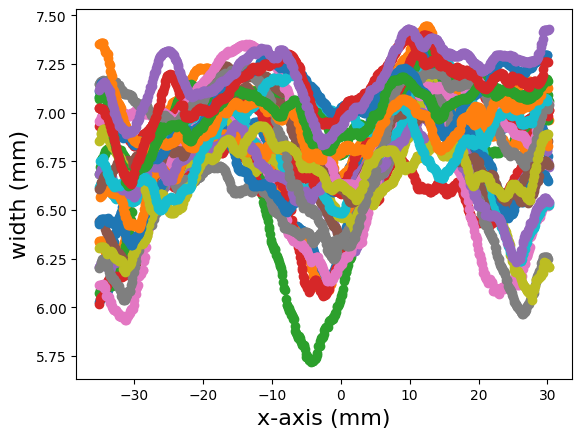

In [8]:
plot_flag=True
f, axw = plt.subplots(1, 1)
all_welds_width=[]
all_welds_height=[]
for weld_i in range(num_samples):
    all_welds_width.append({})
    all_welds_height.append({})

##### cross section parameters
z_height_start=offset


resolution_z=0.1
windows_z=0.2
resolution_x=0.1
windows_x=1
stop_thres=20
stop_thres_w=10
use_points_num=5 # use the largest/smallest N to compute w
width_thres=0.8 # prune width that is too close
all_x_min=[]
all_x_max=[]
for idx, layer in enumerate(layer_points):
    print(layer)
    #### plot w h
    
    #### crop weld
    all_welds_points = o3d.geometry.PointCloud()
        #### get width with x-direction scanning
    
    x_min = -40
    x_max = 35
    all_welds_width[idx]={}
    for x in np.arange(x_min,x_max+resolution_x,resolution_x):
        min_bound = (x-windows_x/2,-1e5,-1e5)
        max_bound = (x+windows_x/2,1e5,1e5)
        bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound,max_bound=max_bound)
        welds_points_x = layer.crop(bbox)
        #visualize_pcd([layer, bbox])
        if len(welds_points_x.points)<stop_thres_w:
            # all_welds_width[weld_i][z][x]=0
            # all_welds_height[weld_i][z][x]=0
            continue
        ### get the width
        sort_y=np.argsort(np.asarray(welds_points_x.points)[:,1])
        y_min_index=sort_y[:use_points_num]
        y_max_index=sort_y[-use_points_num:]
        
        ### get y and prune y that is too closed
        y_min_all = np.asarray(welds_points_x.points)[y_min_index,1]
        y_min = np.mean(y_min_all)
        y_max_all = np.asarray(welds_points_x.points)[y_max_index,1]
        y_max = np.mean(y_max_all)

        actual_y_min_all=[]
        actual_y_max_all=[]
        for num_i in range(use_points_num):
            if (y_max-y_min_all[num_i])>width_thres:
                actual_y_min_all.append(y_min_all[num_i])
            if (y_max_all[num_i]-y_min)>width_thres:
                actual_y_max_all.append(y_max_all[num_i])
        #########
        y_max=0
        y_min=0
        if len(actual_y_max_all)!=0 and len(actual_y_min_all)!=0:
            y_max=np.mean(actual_y_max_all)
            y_min=np.mean(actual_y_min_all)

        this_width=y_max-y_min
        all_welds_width[idx][x]=this_width
        z_height_ave = np.mean(np.asarray(welds_points_x.points)[np.append(y_min_index,y_max_index),2])
    ### get all zx coord
    x_coord=np.array(list(all_welds_width[idx].keys()))
    x_width=np.array(list(all_welds_width[idx].values()))
    if plot_flag:
        ### plot width
        axw.plot(x_coord,x_width,marker='o', label='Layer'+str(idx))
    
    layer.paint_uniform_color(mcolors.to_rgb(table_colors[0]))
    all_welds_points+=layer

if plot_flag:
    # points_proj.paint_uniform_color([1, 0, 0])
    # welds_points.paint_uniform_color([0, 0.8, 0])
    #visualize_pcd([all_welds_points])
    #axw.set_ylim([0, axw.get_ylim()[1]+axw.get_ylim()[1]/5])
    #axw.tick_params(axis="x", labelsize=14) 
    #axw.tick_params(axis="y", labelsize=14) 
    plt.ylabel('width (mm)',fontsize=16)
    plt.xlabel('x-axis (mm)',fontsize=16)
    #plt.legend()
    plt.show()

In [9]:
widths = []
for layer in all_welds_width: 
    for width in list(layer.values()):
        widths.append(width)
    
print("Average Width: ", np.average(widths))
pickle.dump(widths, open(data_dir+'ref_width_7.pickle','wb'))

Average Width:  6.840353128870077
